# Quick description:

**Context**
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Business Goal**
We will be using the online retail trasnational dataset to build a RFM clustering and choose the best set of customers which the company should target.

## Data was taken from https://www.kaggle.com/hellbuoy/online-retail-customer-clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

In [2]:
data = pd.read_csv("OnlineRetail.csv")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# Data Exploration Plan

As a first step I checked data for the number of missing values and the info about numberic columns in dataset

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


As you can see below there is about 135080 values in CustomerID columns and 1454 missing entries in Description part.

In [4]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data cleansing plan

Our data is had many correct entries, so it will not lose much information, if missing rows will be dropped

In [6]:
data = data.dropna()

In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')

# Feature Engineering

Here I constructed 3 new columns, which will help to cluster our clients in different categories.

In [8]:
data['Total'] = data['Quantity'] * data['UnitPrice']
fin_frame = data.groupby('CustomerID')['Total'].sum().reset_index()
print(fin_frame)

      CustomerID    Total
0        12346.0     0.00
1        12347.0  4310.00
2        12348.0  1797.24
3        12349.0  1757.55
4        12350.0   334.40
...          ...      ...
4367     18280.0   180.60
4368     18281.0    80.82
4369     18282.0   176.60
4370     18283.0  2094.88
4371     18287.0  1837.28

[4372 rows x 2 columns]


In [9]:
fin_frame = pd.merge(fin_frame, 
                     pd.DataFrame(data.groupby('CustomerID')['InvoiceNo'].count().reset_index()), on = 'CustomerID',
                     how = 'inner')
fin_frame.head()

,CustomerID,Total,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [10]:
final = data['InvoiceDate'].max()
data['Last_transfer'] = final - data['InvoiceDate']
data['Last_transfer'] = data['Last_transfer'].dt.days
new_df = data.groupby(data['CustomerID']).min()['Last_transfer']
new_df = pd.DataFrame(new_df).reset_index()

In [11]:
fin_frame = pd.merge(fin_frame, new_df, on = 'CustomerID', how = 'inner')
fin_frame.head()

,CustomerID,Total,InvoiceNo,Last_transfer
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0, 0.5, 'Range')

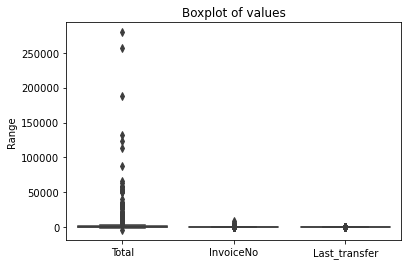

In [12]:
attributes = ['Total','InvoiceNo','Last_transfer']
plt.title("Boxplot of values")
sns.boxplot(data = fin_frame[attributes])
plt.ylabel("Range")

Here I decided to remove outliers for more clear picture of our data to clustering alghorithms. 

In [13]:
Q1 = fin_frame['Total'].quantile(0.10)
Q3 = fin_frame['Total'].quantile(0.90)
IQR = Q3 - Q1
fin_frame = fin_frame[(fin_frame['Total'] >= Q1 - 1.5*IQR) & (fin_frame['Total'] <= Q3 + 1.5*IQR)]

Q1 = fin_frame['InvoiceNo'].quantile(0.10)
Q3 = fin_frame['InvoiceNo'].quantile(0.90)
IQR = Q3 - Q1
fin_frame = fin_frame[(fin_frame['InvoiceNo'] >= Q1 - 1.5*IQR) & (fin_frame['InvoiceNo'] <= Q3 + 1.5*IQR)]

Q1 = fin_frame['Last_transfer'].quantile(0.10)
Q3 = fin_frame['Last_transfer'].quantile(0.90)
IQR = Q3 - Q1
fin_frame = fin_frame[(fin_frame['Last_transfer'] >= Q1 - 1.5*IQR) & (fin_frame['Last_transfer'] <= Q3 + 1.5*IQR)]

In [14]:
fin_frame = fin_frame.drop('CustomerID', axis = 1)
fin_frame.head()

,Total,InvoiceNo,Last_transfer
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


Text(0, 0.5, 'Range')

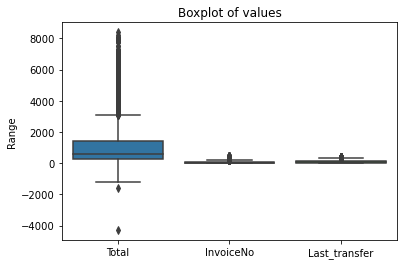

In [15]:
plt.title("Boxplot of values")
sns.boxplot(data = fin_frame)
plt.ylabel("Range")

In [16]:
sc = RobustScaler()
frame_scaled = pd.DataFrame(data = sc.fit_transform(fin_frame), columns = ['Total', 'InvoiceNo', 'Last_transfer'])
frame_scaled.head()

,Total,InvoiceNo,Last_transfer
0,-0.542841,-0.493333,2.091603
1,3.280860,1.906667,-0.381679
2,1.051616,-0.106667,0.175573
3,1.016404,0.453333,-0.251908
4,-0.246172,-0.293333,1.969466


# K-Means 

First clustering techingues will be K-Means clustering, and our purpose to choose some number of clusters, which will fullfil our analysis with insights and divide the data into meaningfull clusters

## Determining the number of clusters

I used 2 metrics for finding optimal number of clusters and gain insights from clusters. 

First one is Elbow method, the heuristic method of finding breaking point from plot of Sum of squared distances between point inside the cluster and number of clusters.

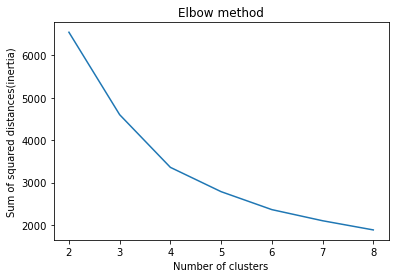

In [17]:
elbow = []
feature_columns = ['Total','InvoiceNo','Last_transfer']
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100, n_init = 10)
    kmeans.fit(frame_scaled)
    elbow.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances(inertia)')
plt.plot(range_n_clusters, elbow)

So the breaking point is 3 or 4, because the plot is not very clear to define the number of clusters, so I will use another metric named Silhouette Score.

Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1. <br>

**1**: Means clusters are well apart from each other and clearly distinguished. <br>
**0**: Means clusters are indifferent, or we can say that the distance between clusters is not significant. <br>
**-1**: Means clusters are assigned in the wrong way.

In [18]:
s_score = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, max_iter=100, n_init = 10)
    kmeans.fit(frame_scaled)
    s_score.append(silhouette_score(frame_scaled, kmeans.labels_))
for i in s_score:
    print("The score for", s_score.index(i) + 2, "the score is", i)

The score for 2 the score is 0.5616851828759848
The score for 3 the score is 0.42867071164379694
The score for 4 the score is 0.4408420421329765
The score for 5 the score is 0.43827249096711635
The score for 6 the score is 0.406396427551728
The score for 7 the score is 0.4086411120625364
The score for 8 the score is 0.3647805957370788


So there is clearly seen that the best practise will be to choose the number of cluster 3, because the difference in silhouette score is not suffficient to add 4th cluster.

In [19]:
kmean_fin = KMeans(n_clusters = 3, max_iter = 100, n_init = 10)
kmean_fin.fit(frame_scaled)
fin_frame['Cluster'] = kmean_fin.predict(frame_scaled[feature_columns])

In [20]:
fin_frame.Cluster.value_counts()

0    2486
1    1059
2     644
Name: Cluster, dtype: int64

<AxesSubplot:xlabel='Cluster', ylabel='Total'>

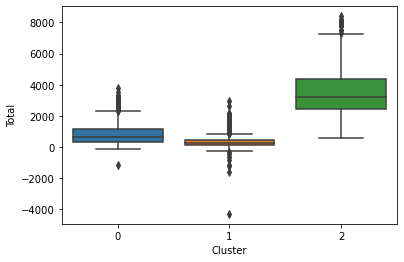

In [21]:
sns.boxplot(x = 'Cluster', y = 'Total', data = fin_frame)

<AxesSubplot:xlabel='Cluster', ylabel='InvoiceNo'>

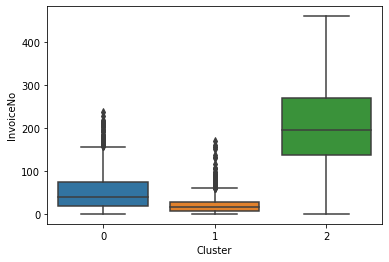

In [22]:
sns.boxplot(x = 'Cluster', y = 'InvoiceNo', data = fin_frame)

<AxesSubplot:xlabel='Cluster', ylabel='Last_transfer'>

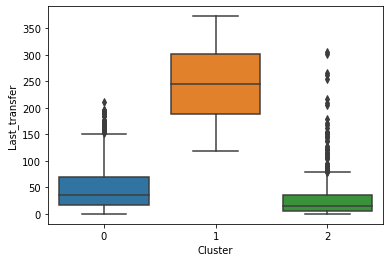

In [23]:
sns.boxplot(x = 'Cluster', y = 'Last_transfer', data = fin_frame)

## Analysis of clusters

As we see from boxplot, our labels, which we get from K-Means represented 3 groups of clients.<br>
1. Active customers(1st place in customer value) - Label 2
2. Recent buyers (2nd place in сustomer value) - Label 0
3. Non-active customers(3rd place in customer value) - Label 1

# Agglomerative Clustering

## Ward Linkage

Here I made an Agglomerative Clustering with ward linkage.

Ward’s method, or minimal increase of sum-of-squares (MISSQ), sometimes incorrectly called "minimum variance" method. Proximity between two clusters is the magnitude by which the summed square in their joint cluster will be greater than the combined summed square in these two clusters: SS12−(SS1+SS2). (Between two singleton objects this quantity = squared euclidean distance / 2.) The metaphor of this built of cluster is type. Intuitively, a type is a cloud more dense and more concentric towards its middle, whereas marginal points are few and could be scattered relatively freely.

In [24]:
ag = AgglomerativeClustering(n_clusters = 3, linkage = 'ward', compute_full_tree = True)
ag = ag.fit(frame_scaled[feature_columns])
fin_frame['Agg_Cluster_ward'] = ag.fit_predict(frame_scaled[feature_columns])

<AxesSubplot:xlabel='Agg_Cluster_ward', ylabel='Total'>

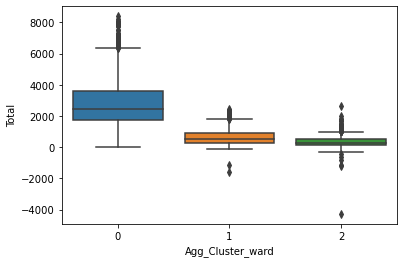

In [25]:
sns.boxplot(x = 'Agg_Cluster_ward', y = 'Total', data = fin_frame)

<AxesSubplot:xlabel='Agg_Cluster_ward', ylabel='InvoiceNo'>

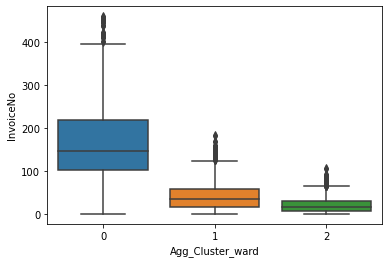

In [26]:
sns.boxplot(x = 'Agg_Cluster_ward', y = 'InvoiceNo', data = fin_frame)

<AxesSubplot:xlabel='Agg_Cluster_ward', ylabel='Last_transfer'>

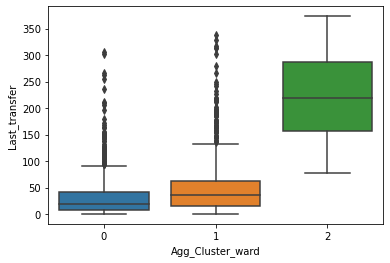

In [27]:
sns.boxplot(x = 'Agg_Cluster_ward', y = 'Last_transfer', data = fin_frame)

### Analysis of clusters

As we see from boxplot, our labels, which we get from Agglomerative Clustering with single linkage represented 3 groups of clients.<br>
1. Active customers(1st place in customer value) - Label 0
2. Recent buyers (2nd place in сustomer value) - Label 1
3. Non-active customers(3rd place in customer value) - Label 2

## Complete Linkage

Method of complete linkage or farthest neighbour. Proximity between two clusters is the proximity between their two most distant objects. This value is one of values of the input matrix. The metaphor of this built of cluster is circle (in the sense, by hobby or plot) where two most distant from each other members cannot be much more dissimilar than other quite dissimilar pairs (as in circle). Such clusters are "compact" contours by their borders, but they are not necessarily compact inside.

In [28]:
ag_sing = AgglomerativeClustering(n_clusters = 3, linkage = 'complete', compute_full_tree = True)
ag_sing = ag_sing.fit(frame_scaled[feature_columns])
fin_frame['Agg_Cluster_complete'] = ag_sing.fit_predict(frame_scaled[feature_columns])

<AxesSubplot:xlabel='Agg_Cluster_complete', ylabel='Total'>

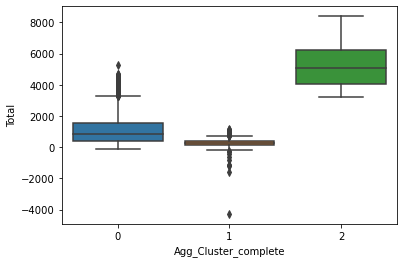

In [29]:
sns.boxplot(x = 'Agg_Cluster_complete', y = 'Total', data = fin_frame)

<AxesSubplot:xlabel='Agg_Cluster_complete', ylabel='InvoiceNo'>

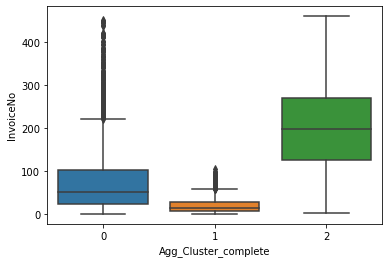

In [30]:
sns.boxplot(x = 'Agg_Cluster_complete', y = 'InvoiceNo', data = fin_frame)

<AxesSubplot:xlabel='Agg_Cluster_complete', ylabel='Last_transfer'>

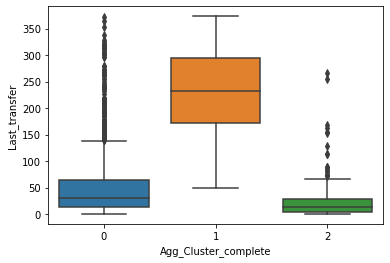

In [31]:
sns.boxplot(x = 'Agg_Cluster_complete', y = 'Last_transfer', data = fin_frame)

### Analysis of clusters

As we see from boxplot, our labels, which we get from Agglomearative clustering with complete linkage represented 3 groups of clients.<br>
1. Active customers(1st place in customer value) - Label 2
2. Recent buyers (2nd place in сustomer value) - Label 0
3. Non-active customers(3rd place in customer value) - Label 1

# Further improvements

I used 3 different cluster techniques and as an improvement, we can make a elections between them and label a client in terms of category, which I decribed above. And choose a category for client, which is more suitable in election. <br>
Also trying different linkage methods can show us different results and can be more appropriate.